
# CNNLSTM windows&val rolling windows alg




This is a deep learning model for times series forecasting.

We take a windows composed by N hours of BTCUSDT-1h data like system input and it predict N+j hours ahead.

The neural network is composed by CNN + LSTM layers and we use pytorch framework

The traing algorithm is built like rolling windows validation where there are nTrWin to train the model and then nValWin to validate the model. Inside theese windows there are N hours of BTCUSDT prices.

In the dataSet we have almost 50k rows and 61 coluns (58 features) and it is group by windows of lenght N by slidingWindows function. Then we divide all dataSet (composed by windows Xin and Yout) in Train&Val dataSet and the last part for test. The original dataSet it is updated each almost month.




## The system schema

Mounted at /content/drive


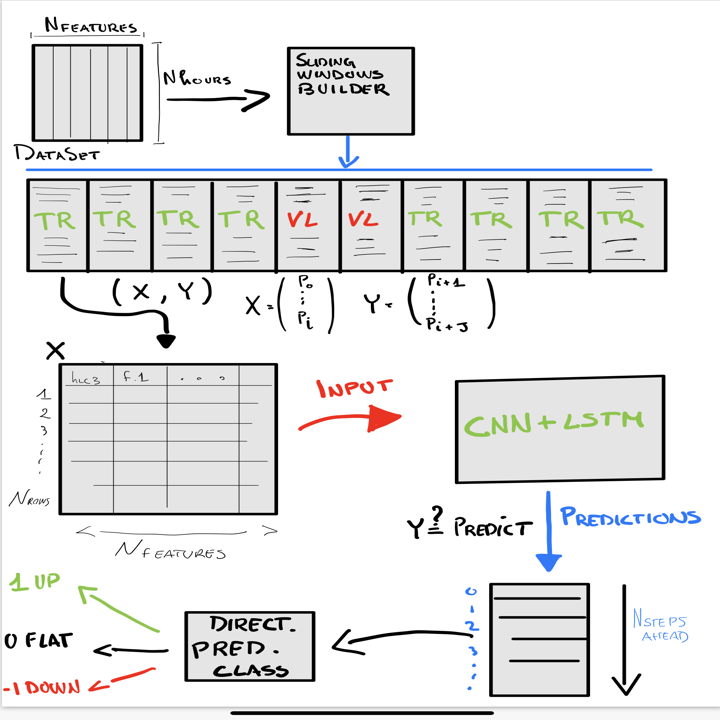

In [2]:
from IPython.display import Image, display
from google.colab import drive
from PIL import Image

drive.mount('/content/drive')
original_image = Image.open("/content/drive/MyDrive/Colab Notebooks/Rmodel/IMG_9F172BA52CAE-1.jpeg")
new_size = (720, 720)
resized_image = original_image.resize(new_size)
display(resized_image)

In [3]:
pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


Stock Market Forecasting Neural Networks for Multi-Output Regression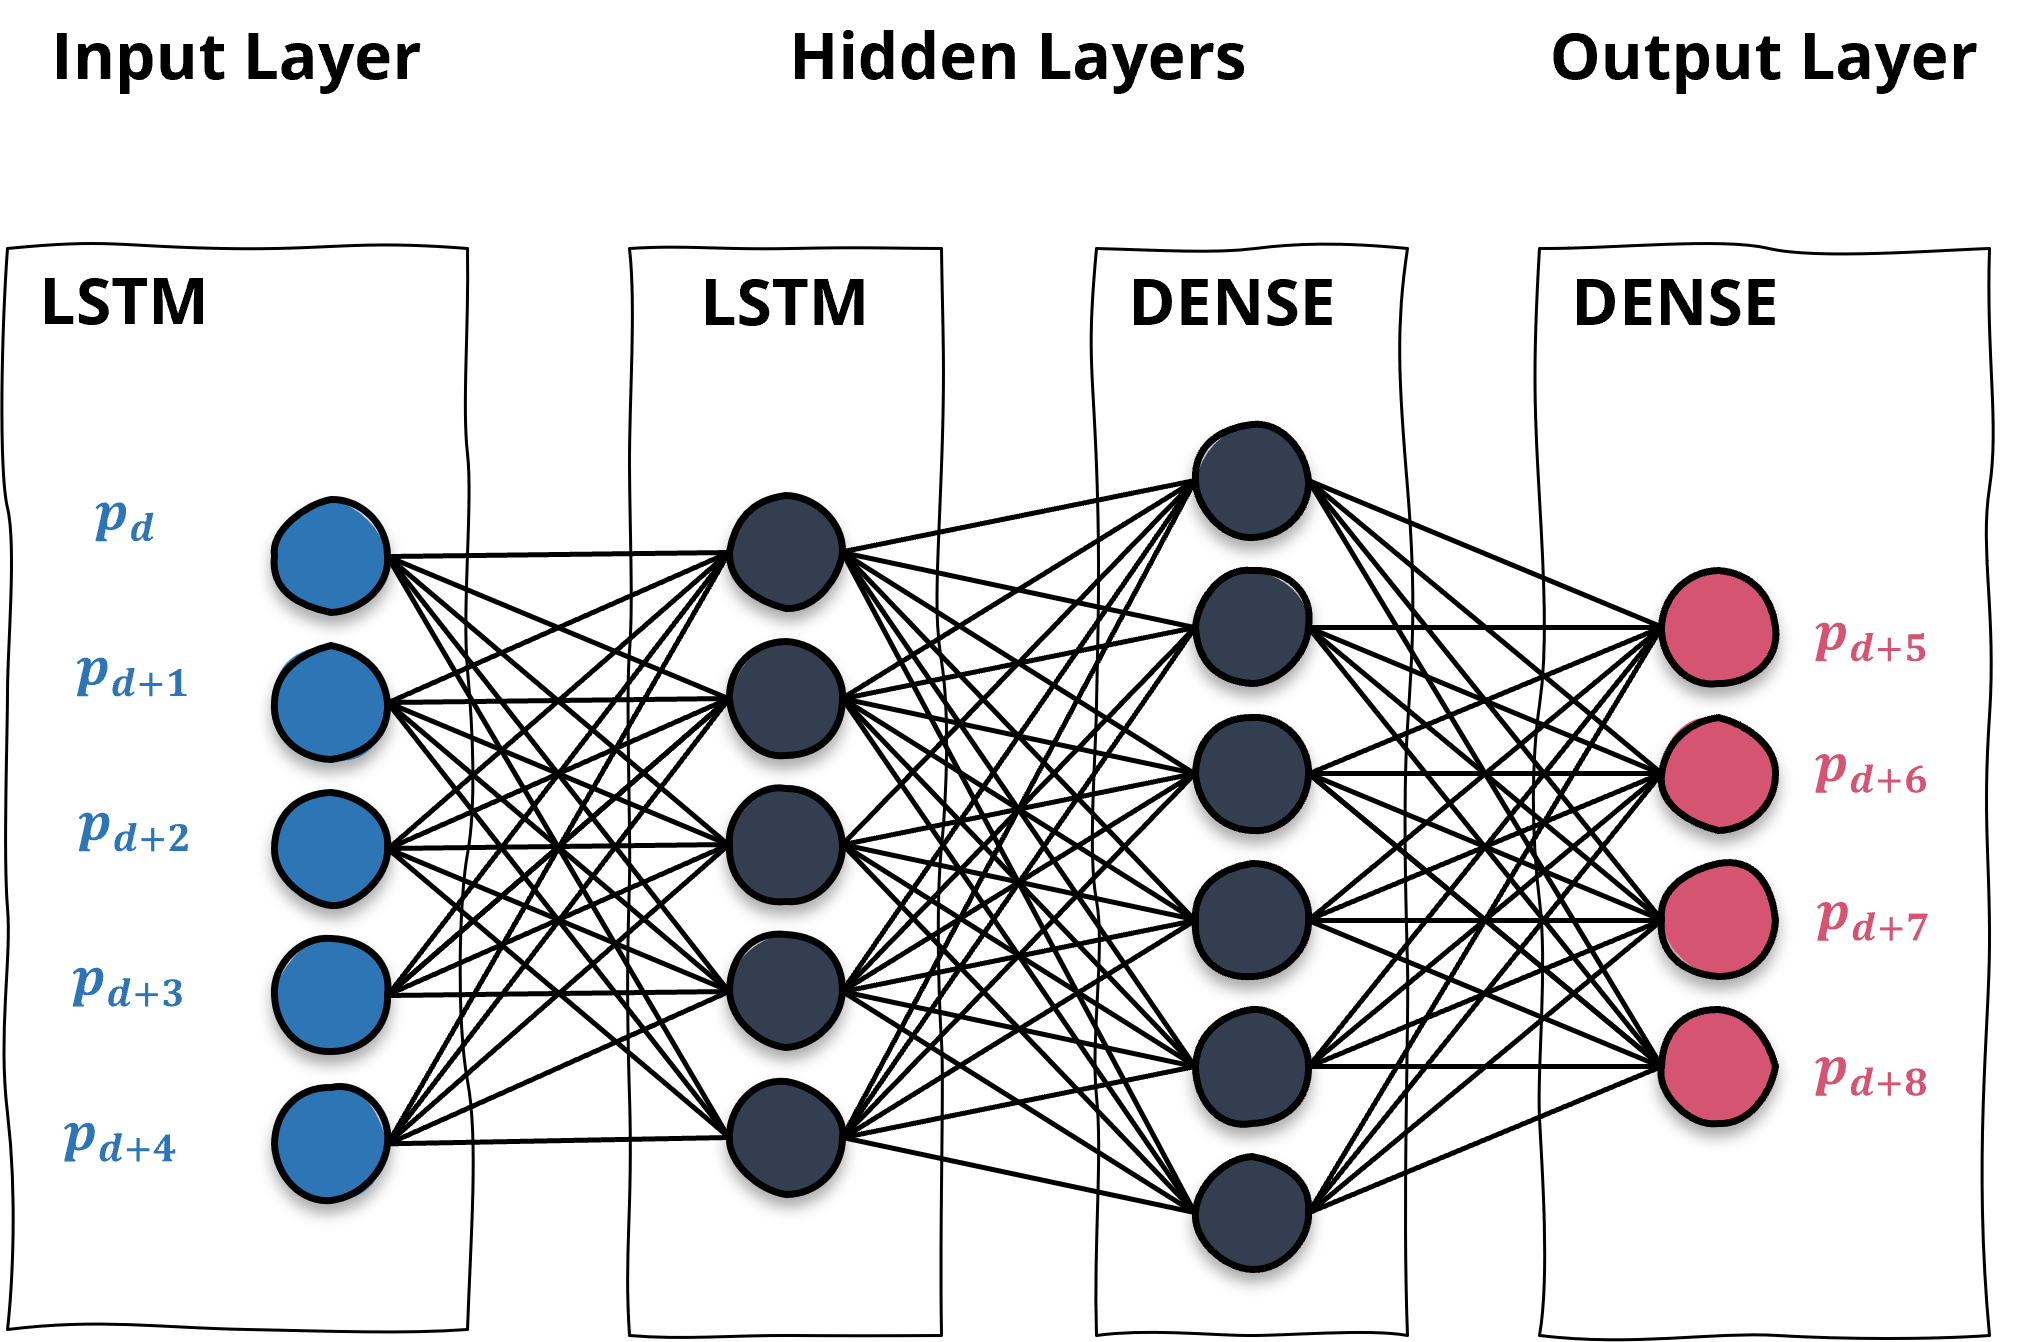



d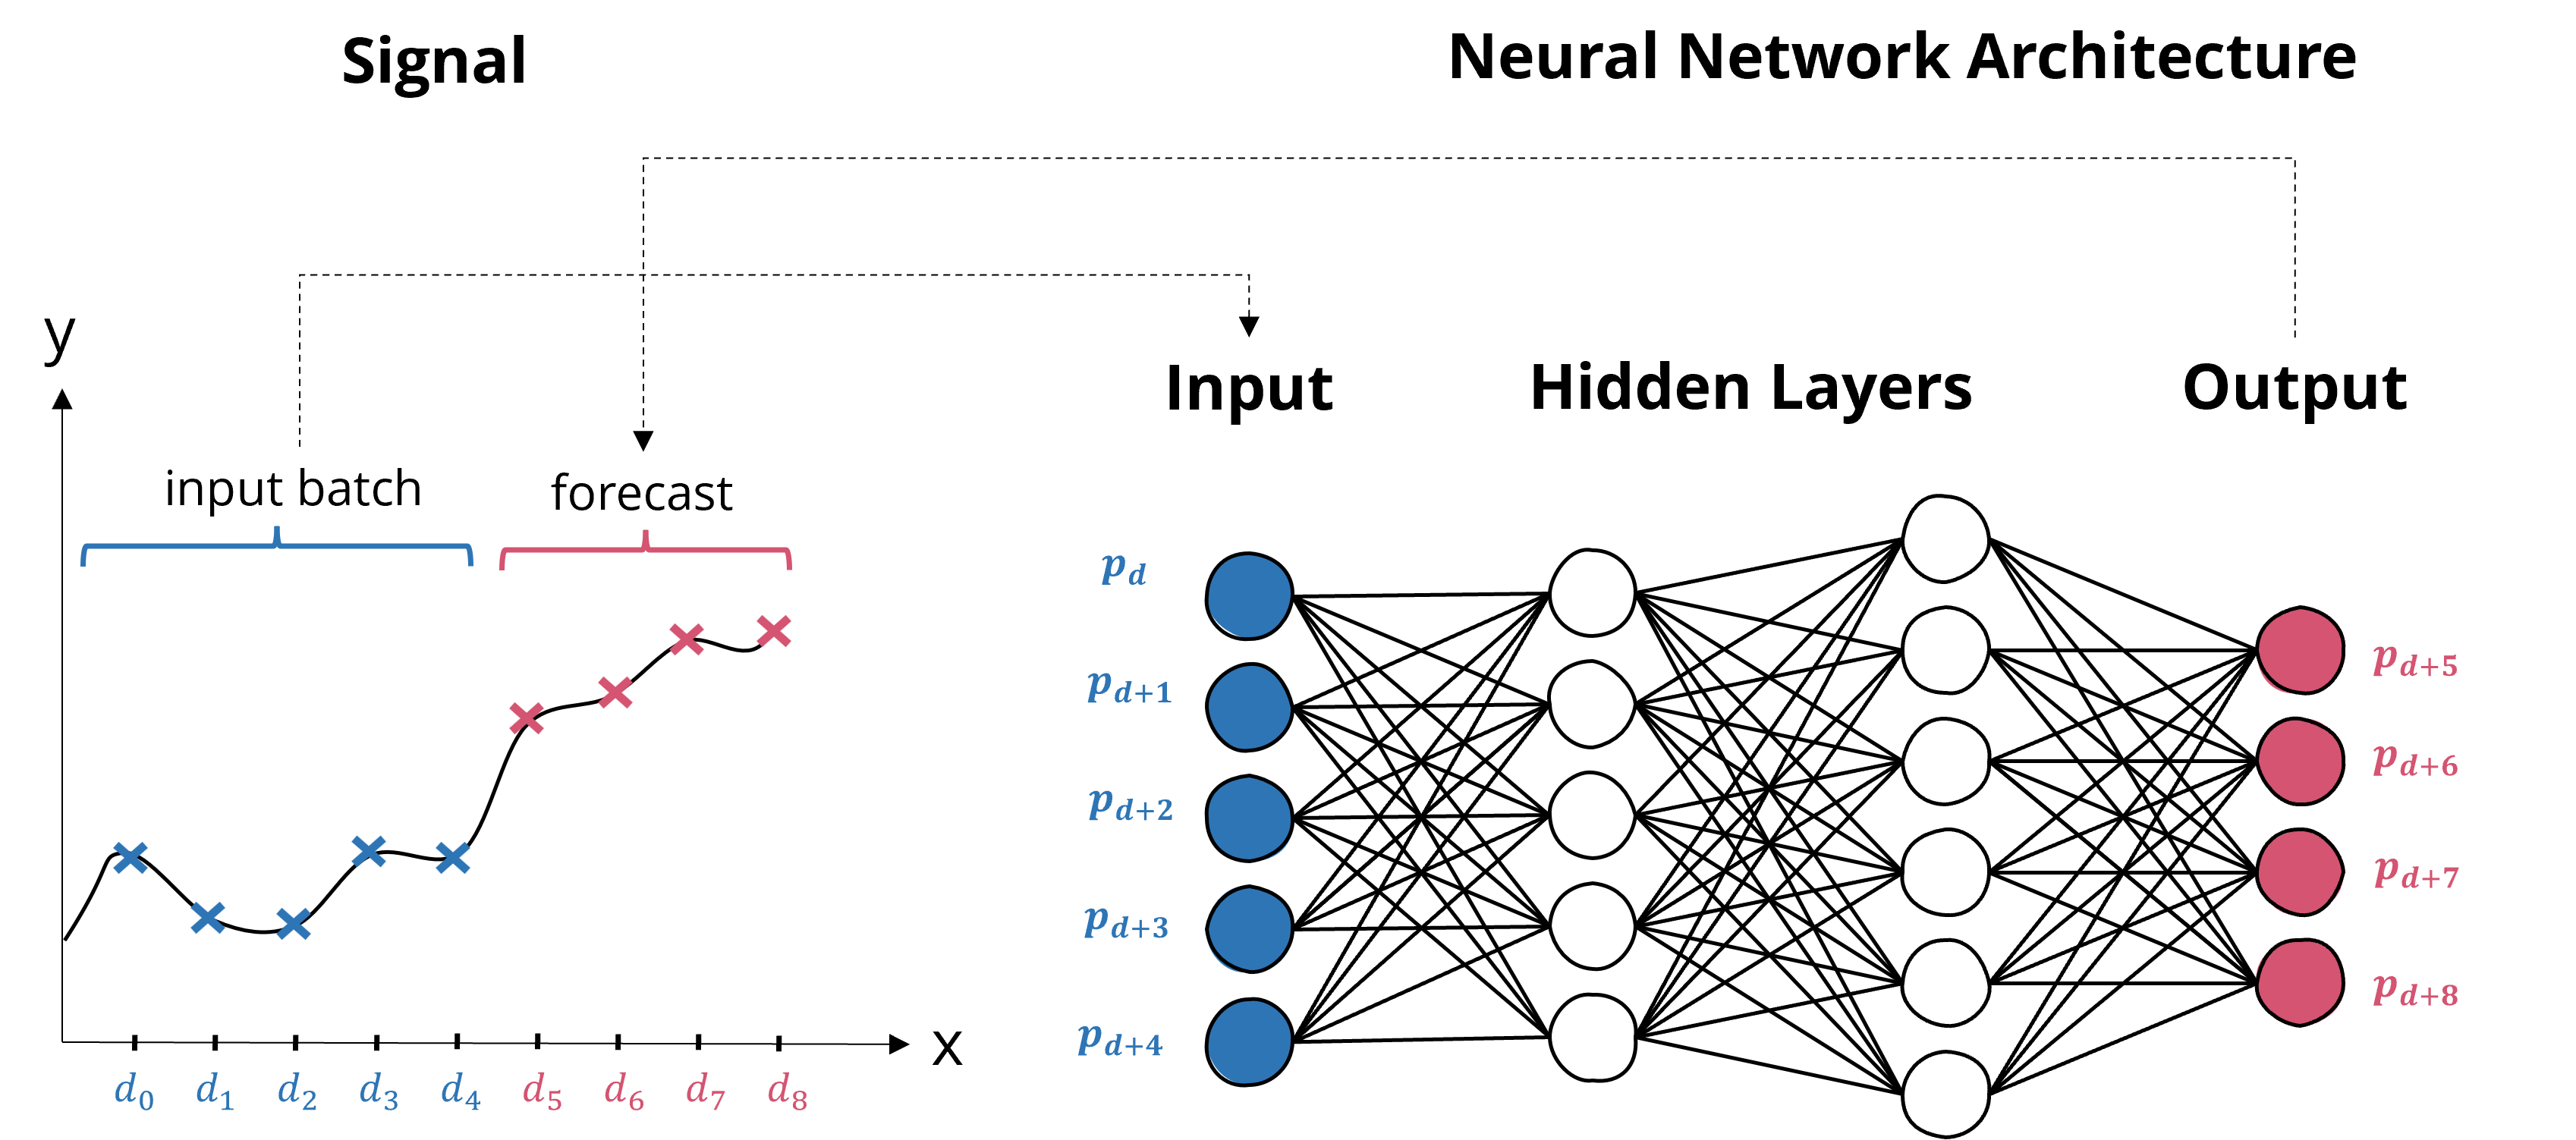The number of neurons in the first layer must match the input data, and the number of neurons in the output layer determines the period length of the predictions.


In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import wandb
from sklearn.preprocessing import MinMaxScaler
import statistics as stat
wandb.login()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# Hyperparameters before fine tuning, these will be displayed on wandb and then there will be fine tuning again through wnadb
setting = {
      "window_size": 64, # var
      "test_split_size": 0.10, # var
      "dimTrValDataSet": 0.90, # var
      "input_size": 61, # fix
      "num_lstm_layers": 1, # var
      "lstm_size": 200, # fix
      "dropout": 0.3, # var
      "nStepsAhead": 24, # var
      "l1_factor": 1e-5, # var
      "weight_decay": 0.001, # var
      "trW": 4, # var
      "vlWl": 2, # var
      "batch_size": 64, # var in [16, 32, 64, 128, 256]
      "num_epochs": 500, # var
      "learning_rate": 3e-4, # Adam # var 0.01 se uso RMSprop
      "optimizer":  "Adam", # "RMSprop"  , # var https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop
      "momentum": 0.8, # var
      "scheduler": "ReduceLROnPlateau", # "CosineAnnealingWarmRestarts", "OneCycleLR" # var
      "scheduler_factor": 0.5, # var
      "scheduler_patience": 3, # var
      "scheduler_min_lr": 1e-6,
      "l1_lambda":0.01,
      "eps": 1e-8,
      "alpha": 0.99,
      "patience": 40,
      "min_delta": 0.005,
      "device": "cuda"


}



In [ ]:
# Dataset download
dataSetClean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRCleaned.csv")
hlc3 = dataSetClean['hlc3']
dataSetClean.drop(labels=['hlc3'], axis=1, inplace=True)
ohlc4 = (dataSetClean['open']+ dataSetClean['close']+ dataSetClean['high']+ dataSetClean['low'])/4
dataSetClean.insert(0, 'ohlc4', ohlc4)


# Dataloading (sliding windows)
setting["input_size"] = dataSetClean.shape[1]  # with 1 have number of features

# Normalize
scaler = MinMaxScaler()
scaler.fit(dataSetClean)
dataSet = scaler.transform(dataSetClean)
dataSet = pd.DataFrame(dataSet)


In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super(). __init__()
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]


def getDataSet(x,y):
    dataSet = TimeSeriesDataset(x, y)
    return dataSet


def getDataLoader(dataSet,confi):
  loader = DataLoader(dataset=dataSet,
                          batch_size=config.batch_size,
                          shuffle=False)
  return loader



In [ ]:
# function to divide the dataSet into windows (X lenght = window_size; Y lenght = nStepsAhead)

def slidingWindowsAhead(df, windowSize, nStepsAhead,dimTrValDataSet):
  x = []
  y = []
  dataLen = df.shape[0] # n rows
  for i in range(windowSize, dataLen, nStepsAhead):
      if i + nStepsAhead > dataLen:
          break  # If we do not have enough data to predict further, we break the loop.
    # '_x' will contain 'windowSize' values as input data
      _x = df.iloc[i-windowSize:i].values
    # '_y' will contain 'nStepsAhead' values as labels
      _y = df.iloc[i:i+nStepsAhead, 0].values
      x.append(_x)
      y.append(_y)

  # convert windows in tensor
  np.array(x)
  np.array(y)
  trVlWnum = int(len(x) * dimTrValDataSet)
  testWnum = len(x) - trVlWnum  # Remaining data for testing

  trVlX = x[:trVlWnum]
  testX = x[trVlWnum:]
  trVlY = y[:trVlWnum]
  testY = y[trVlWnum:]

  print("_______ Dim mX & mY ______")
  print(f"dim mX:{len(x)} dim mY:{len(y)}")
  print("_____Dimension X & Y _____")
  print(f"dim trValX:{len(trVlX)} --- dim trValY:{len(trVlY)} ")

  print(f"dim testX:{len(testX)} --- dim testY:{len(testY)} ")

  # Convert from numpy arrays to torch tensors
  trVlX_tensor = torch.tensor(trVlX, dtype=torch.float32)
  trVlY_tensor = torch.tensor(trVlY, dtype=torch.float32).unsqueeze(1)
  testX_tensor = torch.tensor(testX, dtype=torch.float32)
  testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

  print("_____Dimension X & Y tensor _____")
  print(f"dim TR&VAL X:{trVlX_tensor.shape} --- dim TR&VAL Y:{trVlY_tensor.shape} ")
  print(f"dim TEST X:{testX_tensor.shape} --- dim TEST Y:{testY_tensor.shape} ")

  print(f"trVlX_tensor{trVlX_tensor[:10]}")
  print(f"trVlX_tensor{trVlY_tensor[:10]}")


  return trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor

# Model design

In [ ]:
class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout,
               sequence_length,nStepsAhead):
    super().__init__()

    # model definition
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False),
    )
    self.endLinearLayer = nn.Linear(sequence_length,nStepsAhead)

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    return x

# Service objects

In [ ]:
def getOptimizer(model,config):
  if config.optimizer == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999), eps=config.eps, weight_decay=config.weight_decay, amsgrad=False, foreach=None, maximize=False, capturable=False, differentiable=False, fused=None)
  elif config.optimizer == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate, alpha=config.alpha, eps=config.eps, weight_decay=config.weight_decay, momentum=config.momentum, centered=False, foreach=None, maximize=False, differentiable=False)
  else:
    optimizer = None
  return optimizer


In [ ]:
def getScheduler(optimizer,config):
  if config.scheduler == "ReduceLROnPlateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.scheduler_factor, patience=config.scheduler_patience, min_lr=config.scheduler_min_lr)
  elif config.scheduler == "CosineAnnealingWarmRestarts":
    scheduler = None
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=config.scheduler_patience,T_mult=config.scheduler_factor,eta_min=config.scheduler_min_lr)
  elif config.scheduler == "OneCycleLR":
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=config.scheduler_min_lr,steps_per_epoch=config.num_epochs,epochs=config.num_epochs,pct_start=0.1,cycle_momentum=False)
    scheduler = None
  else:
    scheduler = None
  return scheduler

In [ ]:
def getNweights(model):
  nweights = 0
  for name,weights in model.named_parameters():
    if 'bias' not in name:
      nweights = nweights + weights.numel()

  return nweights

In [ ]:
# inserire anche funzioni di calcolo delle KPI
class ResultManager:
  def __init__(self, all_targets, all_predictions):

      self.all_targets = all_targets
      self.all_predictions = all_predictions
      self.mse = 0
      self.rmse = 0
      self.r2 = 0

  """
  def to_dataframe(self):
    return pd.DataFrame({
      "targets": self.all_targets,
      "predictions": self.all_predictions,
  })
  """

  def to_FlatDataFrame(self):
    all_targets_flat, all_predictions_flat = self.dataFlat()
    return pd.DataFrame({
      "targets": all_targets_flat,
      "predictions": all_predictions_flat,
  })


  def resultPerformance(self):
    return pd.DataFrame({
          "MSE": [self.mse],
          "RMSE": [self.rmse],
          "R2": [self.r2]
      })
  def setMse(self, mse):
    self.mse = mse
  def setRmse(self, rmse):
    self.rmse = rmse
  def setR2(self, r2):
    self.r2 = r2

  def dataFlat(self):
    all_targetsTS_flat = [item for sublist in self.all_targets for item in sublist] if isinstance(self.all_targets[0], list) else self.all_targets
    all_predictionsTS_flat = [item for sublist in self.all_predictions for item in sublist] if isinstance(self.all_predictions[0], list) else self.all_predictions
    return all_targetsTS_flat, all_predictionsTS_flat

  def overallKpiCompute(self):
    all_targetsTS_flat, all_predictionsTS_flat = self.dataFlat()
    self.mse = mean_squared_error(all_targetsTS_flat, all_predictionsTS_flat)
    self.rmse = mean_squared_error(all_targetsTS_flat, all_predictionsTS_flat, squared=False)
    self.r2 = r2_score(all_targetsTS_flat, all_predictionsTS_flat)
    KpiDf = self.resultPerformance()
    # calcola anche la accuracy
    return KpiDf


  def mseStepByStepDf(self):
    dfPredTargetMSE = self.to_FlatDataFrame()
    for i in range(len(dfPredTargetMSE)):
    # Ensure the true and predicted values are passed as lists
      mse = mean_squared_error([dfPredTargetMSE.at[i,"targets"]], [dfPredTargetMSE.at[i,"predictions"]])
      dfPredTargetMSE.at[i, "mse"] = mse

    mse_mean = mean_squared_error(dfPredTargetMSE["targets"], dfPredTargetMSE["predictions"])
    return dfPredTargetMSE

  def tableResultWandb(self,typeDS):
    true_values, predictions = self.dataFlat()
    results_table = wandb.Table(columns=[f"True Values_{typeDS}", f"Predictions_{typeDS}"])

    # Aggiungi i dati alla tabella
    for true, pred in zip(true_values, predictions):
        results_table.add_data(true, pred)

    # Log la tabella su wandb
    wandb.log({"Prediction vs True": results_table})

  def tableResultCSV(self,typeDS):
    true_values, predictions = self.dataFlat()
    df = pd.DataFrame({"True Values": true_values, "Predictions": predictions})
    path_to_save = "/content/drive/MyDrive/Colab Notebooks/ResultOutput/RWIN_CNNLSTM1/OHLC4_prediction[base,NoOPT,24h]/"
    filename = f"RWIN_CNNLSTMohlc4_output_{typeDS}.csv"
    full_path = f"{path_to_save}{filename}"
    df.to_csv(full_path, index=False)
    print("Uploaded {filename} to drive")









In [ ]:
class Plotter:
  def __init__(self, resultManager, config,train_hist,val_hist):
    self.resultManager = resultManager
    self.config = config
    self.val_hist = val_hist
    self.train_hist = train_hist

  def trVlEpoch(self):
    plt.figure(figsize=(12, 6))
    plt.plot(self.train_hist, label='Training Loss')
    plt.plot(self.val_hist, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def predictionsPlot(self,start = -1,end = -1):
    if start == -1 & end == -1:
      all_targetsTS_flat, all_predictionsTS_flat = self.resultManager.dataFlat()
      plt.figure(figsize=(55, 25))
      plt.plot(all_targetsTS_flat[:-1], label='True Value')
      plt.plot(all_predictionsTS_flat[:-1], label='Predicted Value')
      plt.title('Results')
      plt.xlabel('Time Step')
      plt.ylabel('Value')
      plt.legend()
      plt.show()
    else:
      all_targetsTS_flat, all_predictionsTS_flat = self.resultManager.dataFlat()
      plt.figure(figsize=(55, 25))
      plt.plot(all_targetsTS_flat[start:end], label='True Value')
      plt.plot(all_predictionsTS_flat[start:end], label='Predicted Value')

      for i in range(start, end, config.nStepsAhead):
        plt.axvline(x=i, color='k', linestyle='--')

      plt.title('Results')
      plt.xlabel('Time Step')
      plt.ylabel('Value')
      plt.legend()
      plt.show()


  def msePlot(self,start,end):
    dfPredTargetMSE = self.resultManager.mseStepByStepDf()
    mse_mean = mean_squared_error(dfPredTargetMSE["targets"], dfPredTargetMSE["predictions"])
    print(f"Mean MSE over dataset: {mse_mean}")
    plt.figure(figsize=(35, 15))
    plt.plot(dfPredTargetMSE["mse"].iloc[start:end], label='MSE')  # Corrected line
      # Insert a vertical line every 24 steps
    initial = end - start
    for i in range(initial, end, config.nStepsAhead):
      plt.axvline(x=i, color='k', linestyle='--')
    plt.title('MSE')
    plt.xlabel('steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

  def scatter(self):
    y_true_flat, y_pred_flat = self.resultManager.dataFlat()

    # Convert to NumPy arrays
    y_true_flat = np.array(y_true_flat)
    y_pred_flat = np.array(y_pred_flat)

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.5)
    plt.title('Model Performance: True Values vs Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')

    # Plot the perfect prediction line
    max_val = max(y_true_flat.max(), y_pred_flat.max())
    min_val = min(y_true_flat.min(), y_pred_flat.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    plt.show()
















# Service loops

In [ ]:
def train(model,config,loader,optimizer,loss_fn,all_predictionsTR,all_targetsTR,nweights):

  train_loss = 0
  for _, (data,target) in enumerate(loader):

    optimizer.zero_grad()
    data, target = data.to(config.device), target.to(
            config.device)
    target = target.squeeze(1)
    # Forward pass ➡
    outputs = model(data)
    print(f"data:{data} , output {outputs} ")
    trainLoss = loss_fn(outputs,target)

    # Backward pass ⬅

      # reg L1
    L1_term = torch.tensor(0., requires_grad=True).to(config.device)
    for name, weights in model.named_parameters():
        if 'bias' not in name:
          L1_term += torch.sum(torch.abs(weights))
    L1_term /= nweights
    trainLoss += L1_term * config.l1_lambda

    trainLoss.backward()
    max_value = 1.0  # Replace with the maximum gradient norm value you desire
# Inside your training loop, after you call loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_value)
    # Step with optimizer
    optimizer.step()

    train_loss += trainLoss.item()
    all_predictionsTR.extend(
            outputs.squeeze().tolist())  # Flatten and accumulate predictions
    all_targetsTR.extend(
            target.squeeze().tolist())
  avg_loss = train_loss / len(loader)
  return avg_loss






In [ ]:
def validation(model, loader, loss_fn,config,all_predictionsVL,all_targetsVL):
  valLoss = 0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(loader):
      data, target = data.to(config.device), target.to(
        config.device)
      target = target.squeeze(1)
      output = model(data)
      loss = loss_fn(output, target)
      valLoss += loss.item()

    all_predictionsVL.extend(output.squeeze().tolist())  # Flatten and accumulate predictions
    all_targetsVL.extend(target.squeeze().tolist())

  avg_loss = valLoss / len(loader)
  return avg_loss


In [ ]:
def testLoop(model, testX_tensor,testY_tensor,config):
  all_predictionsTS = []
  all_targetsTS = []
  testLoss = 0
  model.eval()
  dataSetTS = getDataSet(testX_tensor,testY_tensor)
  test_loader =getDataLoader(dataSetTS,config)
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config.device), target.to(
        config.device)
      target = target.squeeze(1)
      output = model(data)

      loss = loss_fn(output, target)

      testLoss += loss.item()
      all_predictionsTS.extend(
        output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targetsTS.extend(
        target.squeeze().tolist())



  avg_loss = testLoss / len(test_loader)
  print(f"TestLoss: {avg_loss}")
  return avg_loss,all_predictionsTS,all_targetsTS

In [ ]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = float('inf')

    # return True when validation loss is not decreased by the `min_delta` for `patience` times
    def early_stop_check(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
TRlossHist = [] # per ogni epoca ho la loss di tutte le finestre training
VLlossHist = []


# Traning and Validation in rolling windows

In [ ]:

def trWvalWalg(model, trVlX_tensor,trVlY_tensor, loss_fn, optimizer,scheduler, config,earlyStopper):
  """ algoritmo per il training e la validazione su rolling windows in continuo """
# aggiungere i run per hyperparameters sweep
  nweights = getNweights(model)
  wandb.watch(model, loss_fn, log="all")
  for epoch in range(config.num_epochs):
    train_loss = 0
    val_loss = 0

    all_avgLossTR = []
    all_avgLossVL = []
    all_predictionsTR = []
    all_targetsTR = []
    all_predictionsVL = []
    all_targetsVL = []

    print(f"_______Epoch {epoch}/{config.num_epochs}:_______ \n")

    for i in range(0, len(trVlX_tensor), config.trW + config.vlWl):
      train_indices = slice(i, i + config.trW)
      val_indices = slice(i + config.trW, i + config.trW + config.vlWl)

      if len(trVlX_tensor[train_indices]) > 0:
        model.train()
        train_dataset = getDataSet(trVlX_tensor[train_indices], trVlY_tensor[train_indices])
        train_loader  = getDataLoader(train_dataset,config)

        # training
        avg_TRloss = train(model,config,train_loader,optimizer,loss_fn,all_predictionsTR,all_targetsTR,nweights)

        typeW = "training"
        all_avgLossTR.append(avg_TRloss)
        wandb.log({"trainLossWindows":avg_TRloss, "nWindows":i, "Windows type":typeW, "Epoch":epoch })

      if len(trVlX_tensor[val_indices]) > 0:
        model.eval()
        val_dataset = getDataSet(trVlX_tensor[train_indices], trVlY_tensor[train_indices])
        val_loader  = getDataLoader(val_dataset,config)

        #validation
        avg_VLloss = validation(model,val_loader,loss_fn,config,all_predictionsVL,all_targetsVL)

        typeW = "validation"
        all_avgLossVL.append(avg_VLloss)
        wandb.log({"validationLossWindows":avg_VLloss, "nWindows":i, "Windows type":typeW, "Epoch":epoch })
        scheduler.step(avg_VLloss)

    # scheduler




    # wandDB valloss e trainloss per epoch upload e poi fare una tabella con tutte le predizioni a fronte dei valori coretti
    avgLossTr = stat.mean(all_avgLossTR)
    avgLossVl = stat.mean(all_avgLossVL)
    TRlossHist.append(avgLossTr) # per ogni epoca ho la loss di tutte le finestre training
    VLlossHist.append(avgLossVl) # per ogni epoca ho la loss di tutte le finestre di validazione
    wandb.log({"trainLossEpoch":avgLossTr,  "Epoch":epoch })
    wandb.log({"valLossEpoch":avgLossVl,  "Epoch":epoch })

    print(f"Mean Train Loss: {avgLossTr} \n Val Loss : {avgLossVl} \n")

    # earlyStopper
    """
    if earlyStopper.early_stop_check(avgLossVl):
      print(f"arlyStopper was triggered at epoch:{epoch}")
      break
    """
  return all_predictionsTR,all_targetsTR,all_predictionsVL,all_targetsVL






In [ ]:
def make(config,dataSet):
    # Make the data
    trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor = slidingWindowsAhead(dataSet, config.window_size, config.nStepsAhead,config.dimTrValDataSet)

    # Make the model
    model = CNNLSTMModel(config.input_size,config.num_lstm_layers,config.dropout,
               config.window_size,config.nStepsAhead).to(device)


    # Make the loss and optimizer and custom loss
    loss_fn = torch.nn.MSELoss(reduction='mean') # reduction='mean' qui ci sarà da scrivere una funzione di loss personalizzata
    optimizer = getOptimizer(model,config)
    scheduler = getScheduler(optimizer,config)
    earlyStopper = ValidationLossEarlyStopping(config.patience,config.min_delta)


    return model,trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor, loss_fn, optimizer,earlyStopper,scheduler

# Model pipline

In [ ]:


    # tell wandb to get started
with wandb.init(project="KATY_AI_OHLC4_CNNLSTM", config=setting):
      # access all HPs through wandb.config
  config = wandb.config

      # make the model, data, and optimization problem
  model,trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor, loss_fn, optimizer,earlyStopper,scheduler = make(config,dataSet)

      # and use them to train the model
  all_predictionsTR,all_targetsTR,all_predictionsVL,all_targetsVL = trWvalWalg(model, trVlX_tensor,trVlY_tensor, loss_fn, optimizer,scheduler, config,earlyStopper)

      # and test its final performance
  avg_TestLoss,all_predictionsTS,all_targetsTS =  testLoop(model, testX_tensor,testY_tensor,config)
  resultManagerTS = ResultManager(all_targetsTS, all_predictionsTS)
  resultManagerTR = ResultManager(all_targetsTR, all_predictionsTR)
  resultManagerVL = ResultManager(all_targetsVL, all_predictionsVL)

      # upload to wandb
  resultManagerTS.tableResultWandb("TS")
  resultManagerTS.tableResultCSV("TS")

  resultManagerTR.tableResultWandb("TR")
  resultManagerTR.tableResultCSV("TR")

  resultManagerVL.tableResultWandb("VL")
  resultManagerVL.tableResultCSV("VL")


      # plotter
  plotterTR = Plotter(resultManagerTR, config,TRlossHist,VLlossHist)
  plotterVL = Plotter(resultManagerVL, config,TRlossHist,VLlossHist)
  plotterTS = Plotter(resultManagerTS, config,TRlossHist,VLlossHist)




In [ ]:
#model_filename = "/content/drive/MyDrive/Colab Notebooks/ResultOutput/RWIN_CNNLSTM1_lW{}_TSloss_{:.4f}.pth".format(config.window_size,avg_TestLoss)
#torch.save(model.state_dict(), model_filename)
#print(f'Model saved as {model_filename}')

# Model performance evalutataion

In [ ]:
# Grafico di training e validation loss

plt.figure(figsize=(12, 6))
plt.plot(TRlossHist, label='Training Loss')
plt.plot(VLlossHist, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model KPI

#### KPI on Training windows

In [ ]:

KpiDf = resultManagerTR.overallKpiCompute()
KpiDf.head()

#### KPI on validation windows

In [ ]:
KpiDf = resultManagerVL.overallKpiCompute()
KpiDf.head()

#### KPI on test windows

In [ ]:
KpiDf = resultManagerTS.overallKpiCompute()
KpiDf.head()

## Outputs charts



In [ ]:
plotterTR = Plotter(resultManagerTR, config,TRlossHist,VLlossHist)
plotterVL = Plotter(resultManagerVL, config,TRlossHist,VLlossHist)
plotterTS = Plotter(resultManagerTS, config,TRlossHist,VLlossHist)
plotterTS.predictionsPlot(-1,-1)
plotterTS.predictionsPlot(0,1000)
plotterTS.msePlot(0,1000)
plotterTS.predictionsPlot(0,250)
plotterTS.msePlot(0,250)
plotterTS.scatter()

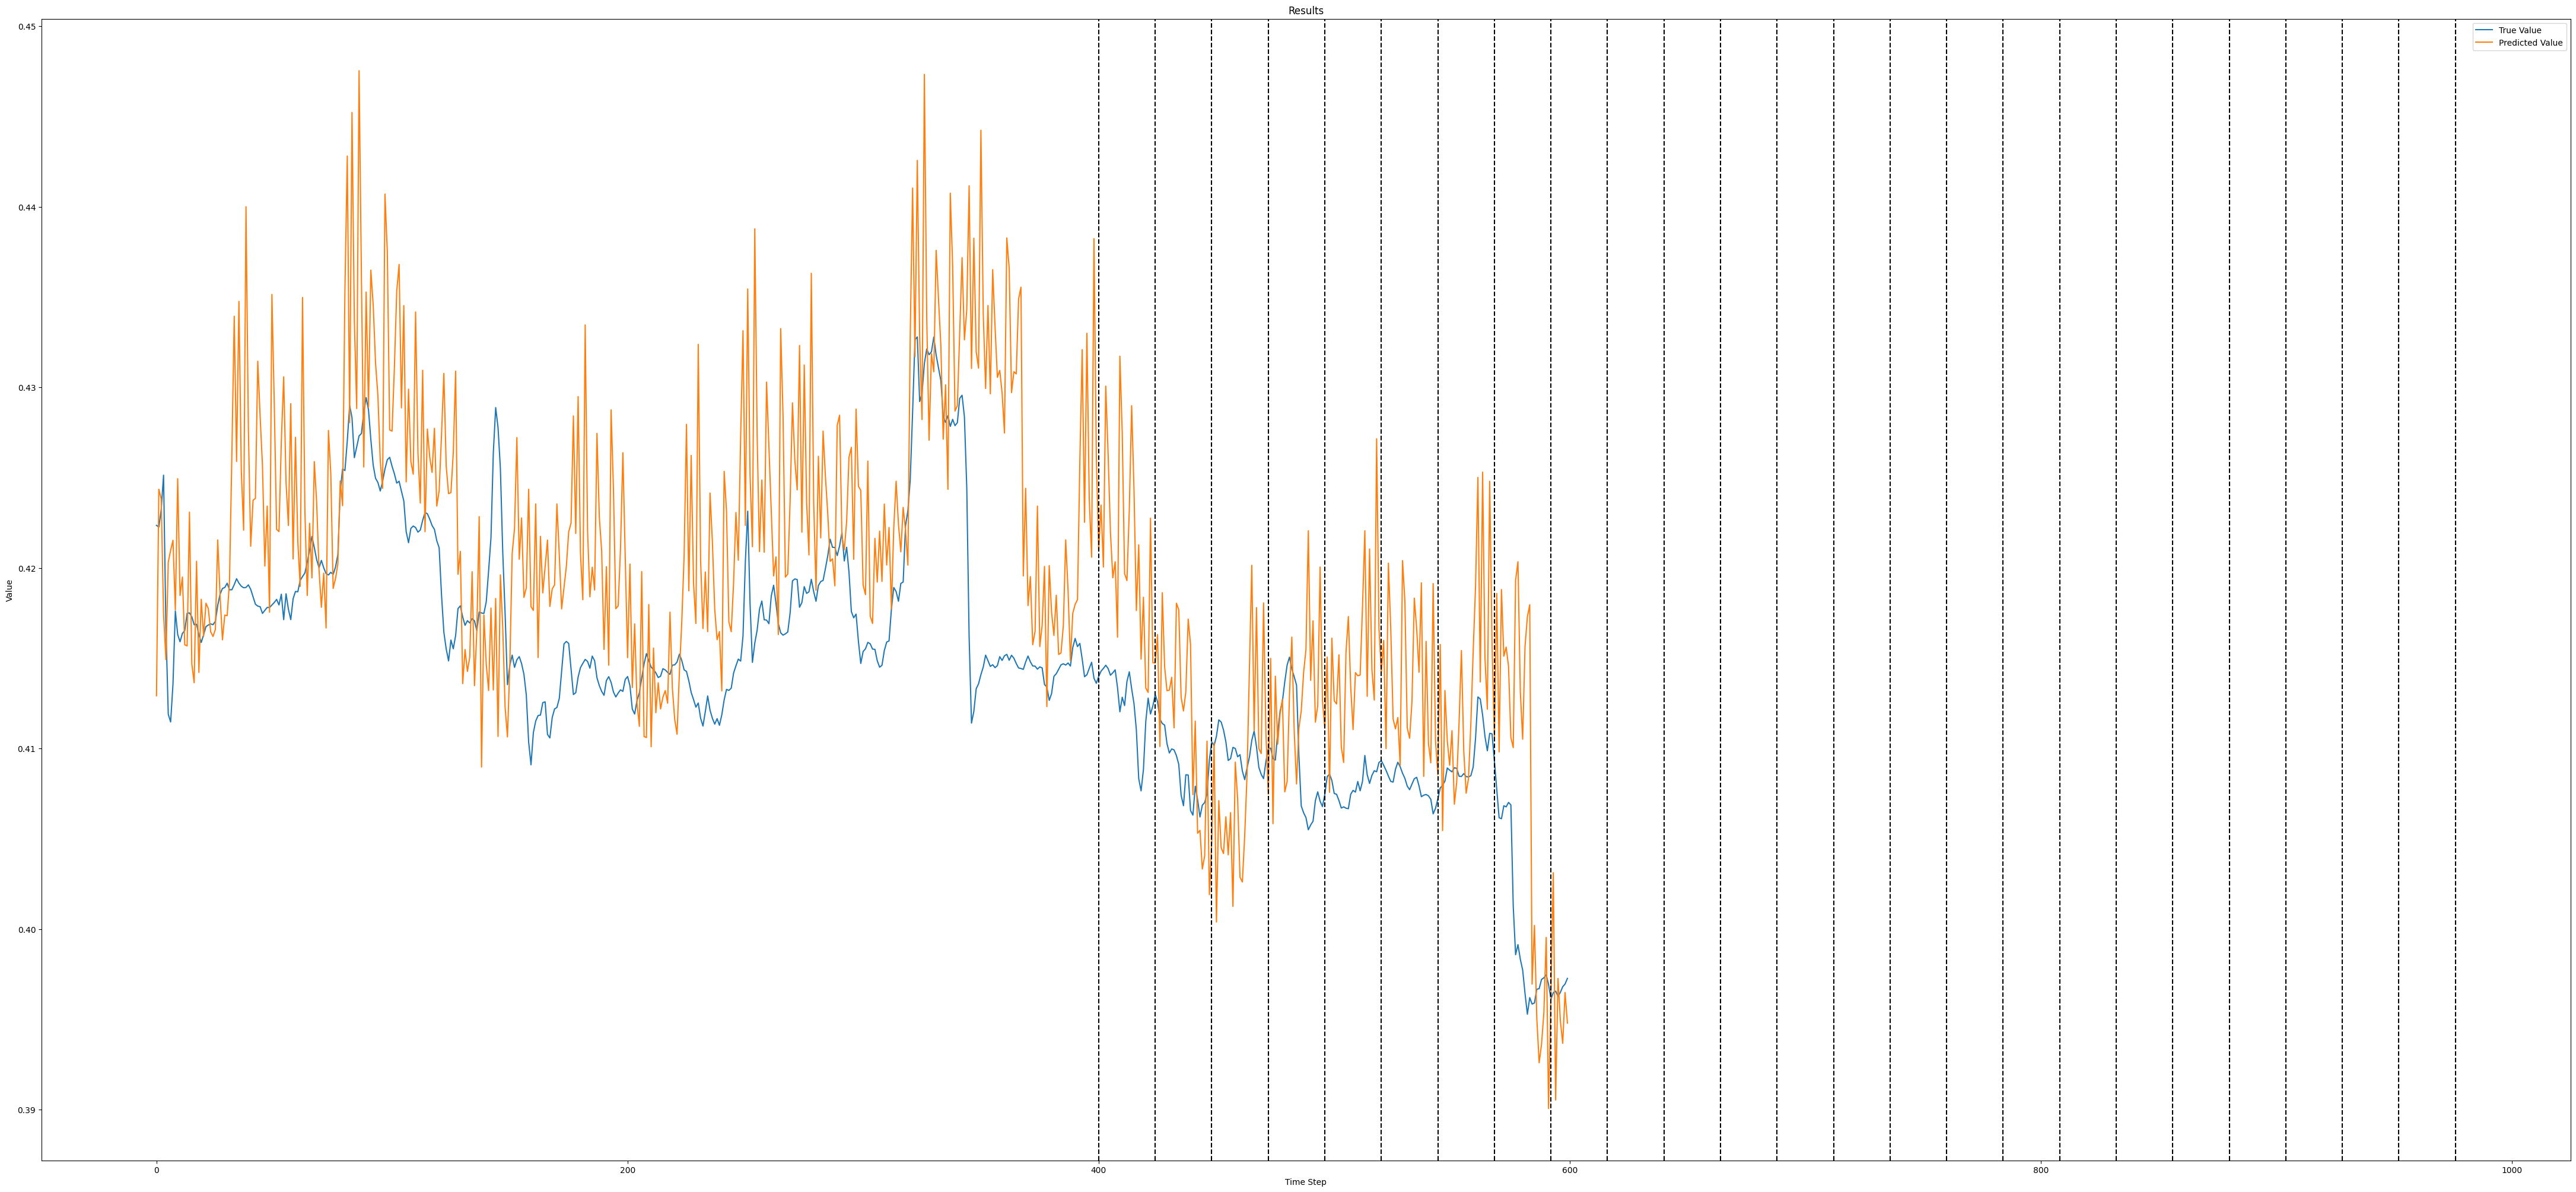

In [ ]:
plotterTS.predictionsPlot(400,1000)


In [ ]:
plotterTS.msePlot(1000,1600)

In [ ]:
print(avg_TestLoss)